# Analyse des données du PIM

## Extraction des données

### Préambule technique

In [1]:
# setting up sys.path for relative imports
from pathlib import Path
import sys
project_root = str(Path(sys.path[0]).parents[1].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# imports and customization of diplay
import io
import pandas as pd
pd.options.display.min_rows = 6
pd.options.display.width=108
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatch

from src.pimapi import Requester

### Récupération des données

Le requêtage des données dans le PIM s'appuie sur la classe `Requester` du module pimapi.

In [3]:
requester = Requester('prd')
# Let's fetch the full content of PIM system
requester.fetch_all_from_PIM()
requester.result

Done


[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>]

A ce stade, les données sont chargées en mémoire sous la forme de fichiers JSON. La conversion des données récupérées par l'API se fait via la méthode `result_to_dataframe` de la classe `Requester`.

In [4]:
df = requester.result_to_dataframe()
df.head(4)

,entity-type,repository,path,type,state,parentRef,isCheckedOut,isVersion,isProxy,changeToken,...,properties.pprodq:visualPhoto.length,properties.pprodq:visualPhoto.data,properties.pprodqmdd:secondaryPackagingPhoto.name,properties.pprodqmdd:secondaryPackagingPhoto.mime-type,properties.pprodqmdd:secondaryPackagingPhoto.encoding,properties.pprodqmdd:secondaryPackagingPhoto.digestAlgorithm,properties.pprodqmdd:secondaryPackagingPhoto.digest,properties.pprodqmdd:secondaryPackagingPhoto.length,properties.pprodqmdd:secondaryPackagingPhoto.data,properties.notif:notifications
uid,,,,,,,,,,,,,,,,,,,,,
afee12c7-177e-4a68-9539-8cbb68442503,document,default,/default-domain/pomSupplierWorkspace/SICO/DEST...,pomProduct,product.waiting.supplier.validation,a58845c0-cab3-492f-b48d-531f146c3777,True,False,False,17-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7d390121-17e8-43bf-a357-9d06b79d2d47,document,default,/default-domain/pomSupplierWorkspace/UNILEVER_...,pomProduct,product.waiting.supplier.validation,a37abc27-f485-4ae9-921b-f761f16c8c1c,False,False,False,15-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f234cd84-c8f6-433f-85ec-6e0b6980adc6,document,default,/default-domain/pomSupplierWorkspace/AZTECA_FO...,pomProduct,product.waiting.supplier.validation,3ff7819a-a392-493f-beb8-0b323ac331c7,True,False,False,33-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e82a8173-b379-41ac-b319-aa058a04fcfb,document,default,/default-domain/pomSupplierWorkspace/UVCDR_-_C...,pomProduct,product.waiting.sending.supplier,e4b5167c-ece2-4f7a-83c1-fb884034a1bf,False,False,False,20-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Définitions pour les mises en formes

### Descriptifs longs

On définit un dictionnaire permettant de "traduire" les codes de champs en libellés long.

In [6]:
lab = {
    'code': 'Code produit', 
    'supplier': 'Code fournisseur',
    'type': 'Type de produit',
    'GTIN': 'GTIN',
    'base_unit': 'Unité de base', 
    'net_weight': 'Poids net',
    'gross_weight': 'Poids brut', 
    'dry_weight': 'Poids net égoutté',
    'volume': 'Volume',
    'total_life': 'Durée de vie totale',
    'remaining_life': 'Durée minimale restante',
    'type_cons': 'Type de conservation',
    'before_open': 'Conservation avant ouv.',
    'after_open': 'Convervation après ouv.',
    'cons_temp': 'Température',  
    'temp_des': 'Libellé temporaire',
    'supplier_des': 'Désignation produit fournisseur',
    'supplier_code': 'Code interne fournisseur',
    'brand': 'Marque commerciale',
    'regulatory_des': 'Dénomination réglementaire',
    'properties.pprodi:supplierDesignation': 'Désignation produit fournisseur',
    'properties.pprodc:ingredientsList': "Liste d'ingrédients",
}

### Champs interessants

On liste également les champs intéressants pour un affichage plus court du dataframe.

In [7]:
def_fields = {'properties.vig:code': 'code',
              'properties.psec:supplierCode': 'supplier',
              'properties.pprodtop:typeOfProduct': 'type',
              'properties.pprodi:gtin': 'gtin',
              'properties.pprodi:supplierDesignation': 'designation'}


## Description des attributs des produit

### Volumétrie des attributs

On constate que chaque produit porte un très grand nombre d'attributs : 

In [8]:
print('Count of columns in df:', len(df.columns))
print('\nInfo of df:')
df.info()

Count of columns in df: 487

Info of df:
<class 'pandas.core.frame.DataFrame'>
Index: 13235 entries, afee12c7-177e-4a68-9539-8cbb68442503 to 6dfce29e-fd4c-4670-9f9c-5c02a5b4d52a
Columns: 487 entries, entity-type to properties.notif:notifications
dtypes: bool(12), float64(60), int64(2), object(413)
memory usage: 48.2+ MB


De plus, de par la nature hiérarchique du format JSON, certains attributs dits "multivalués" sont parfois stockés sous forme de liste dans le dataframe "à plat".
Par exemple, on peut voir que le pays de transformation, ou les facettes, peuvent être multivalués.

In [9]:
df.loc[['609af223-2f14-4f83-a553-cef276f2eca7',
        'c94013e4-0dca-441a-85c1-0b29ecb54d0a',
        '82d1af25-2bdd-4315-9670-67784b70dfa7'],
       ['properties.pprodg:transfoCountries',
        'facets']]

,properties.pprodg:transfoCountries,facets
uid,,
609af223-2f14-4f83-a553-cef276f2eca7,"[PL, FR, ES]","[Versionable, Folderish, Commentable, beginnin..."
c94013e4-0dca-441a-85c1-0b29ecb54d0a,"[DE, NO, BE, RU, CH, BG, LT, GR, FR, UA, HU, E...","[endMigration, Versionable, Folderish, Comment..."
82d1af25-2bdd-4315-9670-67784b70dfa7,[FR],"[endMigration, Versionable, Folderish, Comment..."


De plus, certains attributs sont dits "complexes", car chacune des valeurs de la liste est elle-même un dictionnaire d'attribut.
La combinaison des deux, des attributs "complexes multivalués" existe également. On a alors une liste de dictionnaires. On peut comme ceci imbriquer des niveaux jusqu'à n'importe quelle profondeur.

C'est par exemple le cas des labels qui sont multivalués (un produit peut porter plusieurs labels), qui sont des complexes portant :
- le type de label (bio, Label Rouge, ...)
- la date de fin de validité du label (si applicable)
- le fichier de certification du label (si applicable), qui est lui-même un complexe...


In [10]:
multilabel_ds = df.loc[df['properties.pprodl:labels'].apply(len) > 1, 'properties.pprodl:labels']
for uid, label_list in multilabel_ds.head(3).iteritems():
    print('product uid:', uid)
    for cpt, label in enumerate(label_list):
        print('\n\tlabel', cpt + 1, ':')
        for key, val in label.items():
            print('\t\t', key, ':', val)
    print('-------------------------------------')    

product uid: 362e6230-ba3a-4396-8a47-728b0a1d56db

	label 1 :
		 labelCertificateEndDate : 2024-12-30T23:00:00.000Z
		 typeOfLabel : 80
		 labelCertificateFile : {'name': 'KCC Coleshill Tissue Paper Ecolabel Renewal Certificate Mar 2020.pdf', 'mime-type': 'application/pdf', 'encoding': None, 'digestAlgorithm': 'MD5', 'digest': '6615e3027ff2e014fdc3fa37e67851bb', 'length': '425662', 'data': 'https://produits.groupe-pomona.fr/nuxeo/nxfile/default/362e6230-ba3a-4396-8a47-728b0a1d56db/pprodl:labels/0/labelCertificateFile/KCC%20Coleshill%20Tissue%20Paper%20Ecolabel%20Renewal%20Certificate%20Mar%202020.pdf?changeToken=45-0'}

	label 2 :
		 labelCertificateEndDate : 2022-09-16T22:00:00.000Z
		 typeOfLabel : NA
		 labelCertificateFile : {'name': 'FCC_DoC_Coleshill Mill_PW_blue_Ref13351_Eng V01.pdf', 'mime-type': 'application/pdf', 'encoding': None, 'digestAlgorithm': 'MD5', 'digest': '78cfcc67b8bf0f693e060088f7d97c48', 'length': '84473', 'data': 'https://produits.groupe-pomona.fr/nuxeo/nxfile/

### Description des principaux attributs

On commence par déclarer des utilitaires permettant de mettre en forme les représentations.

In [11]:
# Defining main data to explore
mappings = {
    'identification': {
      'properties.vig:code': 'code',
      'properties.psec:supplierCode': 'supplier',
      'properties.pprodtop:typeOfProduct': 'type',
      'properties.pprodi:gtin': 'GTIN',
    },
    'dimensions': {
        'properties.pprodtop:baseUnit': 'base_unit',
        'properties.pprodg:netWeight': 'net_weight',
        'properties.pprodg:grossWeight': 'gross_weight',
        'properties.pprodg:dryWeight': 'dry_weight',
        'properties.pprodg:volume': 'volume',
    },
    'conservation': {
        'properties.pprodg:totalLife': 'total_life',
        'properties.pprodg:guaranteedLife': 'remaining_life',
        'properties.pprodq:typeOfConservation': 'type_cons',
        'properties.pprodq:conservationBeforeOpening': 'before_open',
        'properties.pprodq:conservationAfterOpening': 'after_open',
        'properties.pprodq:conservationTemperature': 'cons_temp',
    }, 
    'designation': {
        'properties.pprodi:temporaryUnitLabel': 'temp_des',
        'properties.pprodi:supplierDesignation': 'supplier_des',
        'properties.pprodi:internalSupplierProductCode': 'supplier_code',
        'properties.pprodg:supplierCommercialBrand': 'brand',
        'properties.pprodg:regulatoryName': 'regulatory_des',   
    }
  }

# Helper function to transform pandas `to_latex` method output to a tabularx env instead.
def to_tabularx(stringio):
    text = stringio.getvalue()
    text = text.replace(r'\begin{tabular}', r'\begin{tabularx}{\linewidth}')
    text = text.replace(r'\end{tabular}',r'\end{tabularx}')
    return(text)

# Function that saves dataframe as Latex tabularx files as input
def save_to_disk(df, path, lab=lab, tex_label=None):
    text = io.StringIO()
    c_format = 'l' + 'X' * len(df.columns)
    (df.rename(lab, axis=1)
       .to_latex(text,
                 bold_rows=True,
                 column_format=c_format,
                 na_rep='-',
                 label=tex_label,
                 ))    
    with open(path, mode='w') as file:
        file.write(to_tabularx(text))    

### Analyses spécifiques : Statuts

On commence par s'intéresser aux différents statuts des produits.
On commence récupérer certaines valeurs de facettes intéressantes : 
- "begginingMigration": elle signifie que le produit a été repris du système historique (le GIP)
- "endMigration": elle signifie que le produit qui a été créé par reprise fait l'objet d'un processus complet de récupération des données et de contrôle par Pomona

In [12]:
df['begin_mig'] = df['facets'].apply(lambda x: 'beginningMigration' in x)
df['end_mig'] = df['facets'].apply(lambda x: 'endMigration' in x)
print(
(df.loc[:, ['begin_mig', 'end_mig']]
   .reset_index()
   .pivot_table(values='uid', 
                index=['begin_mig'],
                aggfunc='count',
                columns='end_mig',
                fill_value=0,
               )
   .rename({True: 'Créé au démarrage', False: 'Créé après le démarrage'}, axis=0)
   .rename({True: 'Facette fin de migration : Oui', False: 'Facette fin de migration : Non'}, axis=1)
)
)

(df.loc[:, ['begin_mig', 'end_mig']]
   .reset_index()
   .pivot_table(values='uid', 
                index=['begin_mig'],
                aggfunc='count',
                columns='end_mig',
                fill_value=0,
               )
   .rename({True: 'Créé au démarrage', False: 'Créé après le démarrage'}, axis=0)
   .rename({True: 'Facette fin de migration : Oui', False: 'Facette fin de migration : Non'}, axis=1)
).to_latex(
    Path('..') / 'tbls' / 'migration_status.tex',    
    index_names=False,
    column_format='lcc',
    bold_rows=True,
)


end_mig                  Facette fin de migration : Non  Facette fin de migration : Oui
begin_mig                                                                              
Créé après le démarrage                            1680                               0
Créé au démarrage                                  7210                            4345


On peut également voir les statuts courants des produits dans le PIM.

In [13]:
print(df['state'].value_counts())
df['state'].value_counts().to_frame().to_latex(
    Path('..') / 'tbls' / 'products_status.tex',
    column_format = 'lc',
    bold_rows=True,
)

product.validate                          6162
product.waiting.supplier.validation       4833
product.waiting.pomona.validation.niv3     968
product.correct                            653
product.controlAnoMinor                    246
product.waiting.sending.supplier           195
product.controlQualityInProgress            84
product.controlWaitingPomonaValidation      32
product.waiting.pomona.validation.niv2      28
product.waiting.pomona.validation           18
product.inactive                            12
product.validate.reserve                     3
product.controlAnoMajor                      1
Name: state, dtype: int64


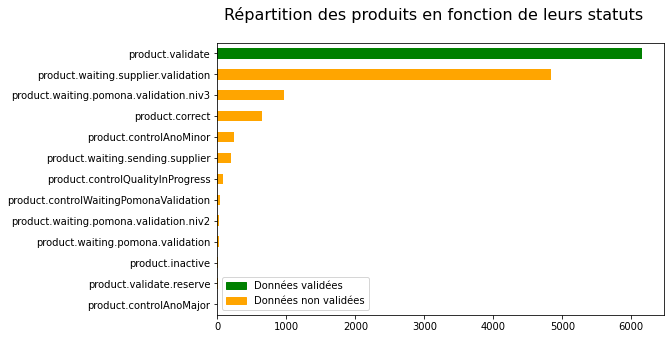

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
color = ['orange'] * len(df['state'].value_counts())
color[-1] = 'g'
incorrect_data = mpatch.Patch(color='orange', label='Données non validées')
correct_data = mpatch.Patch(color='g', label='Données validées')
df['state'].value_counts().sort_values().plot.barh(ax=ax, color=color)
fig.suptitle('Répartition des produits en fonction de leurs statuts',
             fontsize=16)
ax.legend(handles=[correct_data, incorrect_data])
fig.savefig(Path('..') / 'img' / 'products_status.png', bbox_inches='tight')

On calcule un statut spécifique à la validité des données en combinant le statut de migration et le statut du produit.

In [15]:
migration_mask = df.loc[:, 'end_mig'] | ~df.loc[:, 'begin_mig']
status_mask = (df.loc[:, 'state'] == 'product.validate')
df['data_ok'] = migration_mask & status_mask

In [16]:
cur_df = (df.loc[:, 'data_ok']
            .value_counts()
            .rename({False: 'Hors qualité', True: 'En qualité'})
            .rename('Répartition produit par qualité')
            .to_frame()
         )

print(cur_df)

cur_df.to_latex(Path('..') / 'tbls' / 'products_quality.tex',
                bold_rows=True,
                column_format='lc',
                na_rep='-',
                index=True,
                index_names=True,
                )

              Répartition produit par qualité
Hors qualité                             8722
En qualité                               4513


In [17]:
(df.groupby('data_ok')
    [['properties.pprodq:conservationBeforeOpening',
      'properties.pprodg:guaranteedLife']]
    .describe(include='all')
    .stack()
)

properties.pprodq:conservationBeforeOpening  properties.pprodg:guaranteedLife
data_ok                                                                                     
False   count                                         6369                       6068.000000
        unique                                           7                               NaN
        top                             ambientTemperature                               NaN
        freq                                          5731                               NaN
        mean                                           NaN                        345.489288
        std                                            NaN                        371.169490
        min                                            NaN                          0.000000
        25%                                            NaN                        160.000000
        50%                                            NaN                        270.000000
        75%                                            NaN                        480.000000
        max                                            NaN                       9999.000000
True    count                                         3614                       3408.000000
        unique                                           7                               NaN
        top                             ambientTemperature                               NaN
        freq                                          2532                               NaN
        mean                                           NaN                        362.071009
        std                                            NaN                        395.675769
        min                                            NaN                          0.000000
        25%                                            NaN                        180.000000
        50%                                            NaN                        360.000000
        75%                                            NaN                        480.000000
        max                                            NaN                       9999.000000

### Exports des exemples et des descriptions des données structurées

On boucle sur les différents mappings, et on les sauvegardes dans des tableaux latex pour intégration au rapport.

In [18]:
df_dict = dict()

for map_type, mapping in mappings.items():
    cur_df = df.loc[:, list(mapping.keys()) + ['data_ok']].rename(mapping, axis=1).fillna(np.nan)
    df_dict[map_type] = cur_df.copy()
    desc = cur_df.groupby('data_ok').describe(include='all').stack()
    samp = cur_df.sample(n=5, random_state=42)
    print(map_type)
    print(samp.rename(lab, axis=1))
    print('---------------------------------------------------')
    print(desc.rename(lab, axis=1)
              .round(3)
         )
    print('---------------------------------------------------')
    
    # Writing dataframes to .tex files
    text = io.StringIO()
    c_format = 'l' + 'X' * len(cur_df.columns)
    (samp.rename(lab, axis=1)
         .to_latex(text,
                   bold_rows=True,
                   column_format=c_format,
                   na_rep='-'
                   ))
    with open(Path('..') / 'tbls' / ('Exemple '+ map_type +'.tex'), mode='w') as file:
        file.write(to_tabularx(text))

    text = io.StringIO()    
    (desc.rename(lab, axis=1)
         .rename({False: 'Hors qualité', True: 'En qualité'})
         .round(3)
         .to_latex(text,
                   bold_rows=True,
                   column_format=c_format,
                   na_rep='-',
                   #index_names=False,
                   multirow=True,
                   ))
    with open(Path('..') / 'tbls' / ('Desc '+ map_type +'.tex'), mode='w') as file:
        file.write(to_tabularx(text))
    

identification
                                         Code produit Code fournisseur    Type de produit           GTIN  \
uid                                                                                                        
e24f6685-40da-4fc8-8454-ec70282552be  PIMP-0000009877  PIMF-0000000483     alcoholicDrink  3387210001261   
a4e317c3-f8d6-441d-82fc-13f5288ba137  PIMP-0000013133  PIMF-0000000283            hygiene  3342690134229   
729883ee-8d83-45a3-a7c7-015b22473ac9  PIMP-0000007508  PIMF-0000000378            grocery  3077317320227   
4312cd74-4708-4216-a56e-fbc404c5afa0  PIMP-0000012015  PIMF-0000000596            grocery  3230140003938   
2581a202-7737-448f-9e2d-eb5a02472101  PIMP-0000008730  PIMF-0000000311  nonAlcoholicDrink  5449000227089   

                                      data_ok  
uid                                            
e24f6685-40da-4fc8-8454-ec70282552be     True  
a4e317c3-f8d6-441d-82fc-13f5288ba137    False  
729883ee-8d83-45a3-a7c7-015b22473ac9

designation
                                                            Libellé temporaire  \
uid                                                                              
e24f6685-40da-4fc8-8454-ec70282552be   Pays d'Oc Viognier blanc IGP en BIB 5 L   
a4e317c3-f8d6-441d-82fc-13f5288ba137                    COUVERCLE GOBELET 8 OZ   
729883ee-8d83-45a3-a7c7-015b22473ac9   Vinaigre de riz en bouteille 50 cL BEAU   
4312cd74-4708-4216-a56e-fbc404c5afa0  MOUTARDE BOURGOGNE IGP SEAU 1.1KG FALLOT   
2581a202-7737-448f-9e2d-eb5a02472101   Citronnade en bouteille 50 cl MINUTE MA   

                                                        Désignation produit fournisseur  \
uid                                                                                       
e24f6685-40da-4fc8-8454-ec70282552be  Pays d'Oc Viognier blanc IGP en BIB 5 L VINS P...   
a4e317c3-f8d6-441d-82fc-13f5288ba137                    COUVERCLE PR GOBELET CARTON 8OZ   
729883ee-8d83-45a3-a7c7-015b22473ac9         Vina

### Analyses spécifiques : GTIN

On peut mettre en évidence les produits qui portent les mêmes GTIN en double. En y jetant un oeil rapide, quelques explications peuvent être trouvées : 
- il peut s'agir d'un changement de code fournisseur (les 2 premières lignes ne portent pas le même code fournisseur)
- il peut s'agir d'un changement de recette côté industriel, qui a décidé de conserver le même GTIN (second couple)
- il peut s'agir d'une erreur, et de produits en doublon dans le système (troisième couple)
- ...

In [19]:
GTIN_mask = (df['properties.pprodi:gtin'] != '') & ~(pd.isna(df['properties.pprodi:gtin']))
dups_mask = df.loc[GTIN_mask, 'properties.pprodi:gtin'].duplicated(keep=False)
examples = (df.loc[GTIN_mask & dups_mask, def_fields.keys()]
              .rename(def_fields, axis=1)
              .sort_values('gtin')
              .head(8))
save_to_disk(examples,
             Path('..') / 'tbls' / 'Duplicated_GTIN.tex',
             lab={},
             tex_label='tab:dup_gtin',
            )
print(examples)

                                                 code         supplier     type            gtin  \
uid                                                                                               
048712e3-f145-4f40-b8ad-7c0b912983bd  PIMP-0000009515  PIMF-0000000420  grocery   0020176760607   
4de8ce87-8df5-440c-959d-3d77d59bb4f3  PIMP-0000013159  PIMF-0000000182  grocery   0020176760607   
7e455046-def3-4526-a28b-bc5c0e6e64fc  PIMP-0000011456  PIMF-0000000290  grocery  03344540125906   
a92c6ac5-d5be-4f92-98b3-9f6c588f7613  PIMP-0000013198  PIMF-0000000290  grocery  03344540125906   
66590f04-5eae-4829-b0da-c899a18dd9cb  PIMP-0000010839  PIMF-0000000250  grocery   3011360083845   
27e20042-dc53-46b4-874c-f970db554aec  PIMP-0000001494  PIMF-0000000250  grocery   3011360083845   
52d3f309-e402-4931-974c-b6b6fa721aff  PIMP-0000002337  PIMF-0000000348  grocery   3038353024906   
02803e27-487a-43e3-9324-9ad1660b63b2  PIMP-0000002338  PIMF-0000000348  grocery   3038353024906   

         

Si l'on produit la répartition du nombre de produit portant un GTIN donné dans le système, on obtient :

                     Nb de GTIN
Pdt portant le GTIN            
1                         11089
2                           228
3                            21
4                            20
5                             1


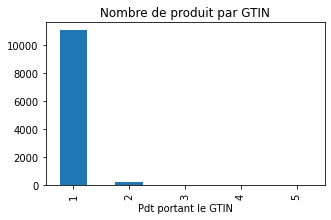

In [20]:
df2 = (df.pivot_table(values='properties.vig:code',
                      index='properties.pprodi:gtin',
                      aggfunc='count')
        .rename({'properties.vig:code': 'code_count'}, axis=1)
      )

df2 = (df2.reset_index()
          .loc[df2.index != '']
          .pivot_table(index='code_count',
                       aggfunc='count',
                       values='code_count')
          .rename({'properties.pprodi:gtin': 'Nb de GTIN'},
                  axis=1)
)

df2.index.rename('Pdt portant le GTIN', inplace=True)

print(df2)

save_to_disk(df2,
             Path('..') / 'tbls' / 'gtin_counts.tex')

fig, ax = plt.subplots(figsize=(5,3))
df2.plot(kind='bar', legend=None, title='Nombre de produit par GTIN', ax=ax)
fig.savefig(Path('..') / 'img' / 'repartition_gtin.png', bbox_inches='tight')

### Analyse spécifique : distribution par fournisseur

On peut représenter la distribution produit, par fournisseur.

In [21]:
# construction the counts
counts = (df.loc[:, list(def_fields.keys())]
            .rename(def_fields, axis=1)
            .pivot_table(values='code',
                         index='supplier',
                         aggfunc='count')
            .reset_index()
            .pivot_table(values=['supplier', 'code'],
                         index='code',
                         aggfunc={'supplier': 'count',
                         'code': 'sum'})
)

# aligning index to have it countinuous
new_idx = pd.RangeIndex(start=1, stop=max(counts.index) + 1)

counts = (counts.reindex(new_idx)
                .fillna(0)
)

counts = pd.concat([counts,
                    counts.cumsum().rename({'code': 'cum_code', 'supplier': 'cum_supplier'},
                                           axis=1),
                   ],
                   axis=1)

for feature in ['supplier', 'code']:
    counts['cump_' + feature] = 100 * counts['cum_' + feature] / counts.loc[:, 'cum_' + feature].iloc[-1]

counts

,code,supplier,cum_code,cum_supplier,cump_supplier,cump_code
1,78.0,78.0,78.0,78.0,12.850082,0.589346
2,140.0,70.0,218.0,148.0,24.382208,1.647148
3,183.0,61.0,401.0,209.0,34.431631,3.029845
...,...,...,...,...,...,...
368,0.0,0.0,12496.0,605.0,99.670511,94.416320
369,369.0,1.0,12865.0,606.0,99.835255,97.204382
370,370.0,1.0,13235.0,607.0,100.000000,100.000000


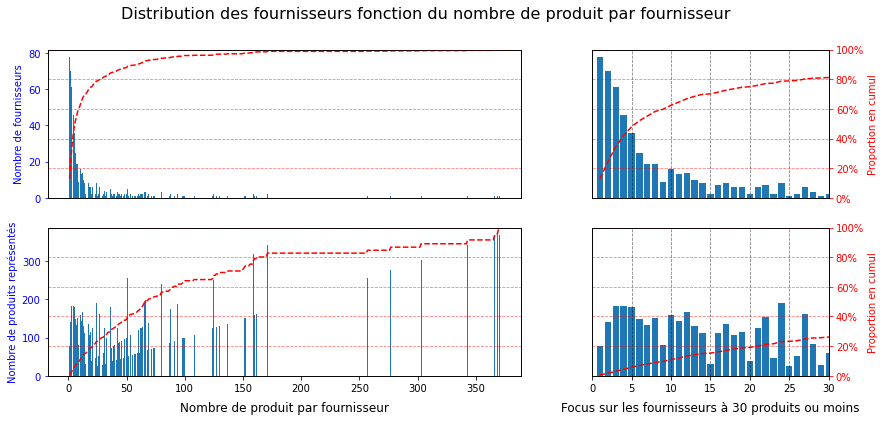

In [22]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(14, 6),
                        gridspec_kw= {'width_ratios': [2, 1]})

axs2 = [[ax.twinx() for ax in axrow] for axrow in axs]

for i, feature in enumerate(['supplier', 'code']):
    axs[i][0].bar(data=counts.loc[:, feature].reset_index(), x='index', height=feature)
    axs2[i][0].plot('index', 'cump_' + feature, data=counts.loc[:, 'cump_' + feature].reset_index(),
                    color='red', linestyle='--')
    axs2[i][0].grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
    
    axs[i][1].bar(data=counts.loc[:, feature].reset_index(), x='index', height=feature)
    axs2[i][1].plot('index', 'cump_' + feature, data=counts.loc[:, 'cump_' + feature].reset_index(),
                    color='red', linestyle='--')
    axs2[i][1].grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
    
    axs[i][1].set_xlim(0, 30)
    
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs2[i][j].set_ylim(0, 100)
        # remove all bottom ticks except for bottom line
        # set_yticks does not work as it removes the grid
        if i < len(axs) - 1:
            axs[i][j].set_xticklabels([])
            for tic in axs[i][j].xaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
        # remove all right ticks except for right column
        # set_yticks does not work as it removes the grid
        if j < len(axs[i]) - 1: 
            axs2[i][j].set_yticklabels([])
            for tic in axs2[i][j].yaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
        # remove all left ticks except for first column
        if j > 0: 
            axs[i][j].set_yticks([])
        if j == len(axs[i]) - 1:
            axs2[i][j].tick_params(axis='y', colors='red')
            axs2[i][j].yaxis.set_major_formatter(ticker.PercentFormatter())
            axs2[i][j].set_ylabel('Proportion en cumul', color='red')
            axs[i][j].grid(True, axis='x', color='k', alpha=0.5, linestyle='--')
        if j == 0:
            axs[i][j].tick_params(axis='y', colors='blue')
            if i == 0: 
                axs[i][j].set_ylabel('Nombre de fournisseurs', color='blue')
            if i == 1:
                axs[i][j].set_ylabel('Nombre de produits représentés', color='blue')
axs[1][0].set_xlabel('Nombre de produit par fournisseur', 
                     fontsize=12,
                     labelpad=8,
                    )
axs[1][1].set_xlabel('Focus sur les fournisseurs à 30 produits ou moins', 
                     fontsize=12,
                     labelpad=8,
                    )

fig.suptitle('Distribution des fournisseurs fonction du nombre de produit par fournisseur',
             fontsize=16,
            )

fig.savefig(Path('..') / 'img' / 'distribution_fournisseurs_par_prd_count.png', bbox_inches='tight')

On peut également représenter le nombre de produits "récupérés" si on prend les fournisseurs par nombre de produits décroissant.

In [23]:
# construction the counts
counts = (df.loc[:, list(def_fields.keys())]
            .rename(def_fields, axis=1)
            .pivot_table(values='code',
                         index='supplier',
                         aggfunc='count')
            .sort_values('code', ascending=False)
)
counts['code_cumsum'] = counts['code'].cumsum()
counts

,code,code_cumsum
supplier,,
PIMF-0000000179,370,370
PIMF-0000000250,369,739
PIMF-0000000283,366,1105
...,...,...
PIMF-0000000522,1,13233
PIMF-0000000233,1,13234
PIMF-0000000005,1,13235


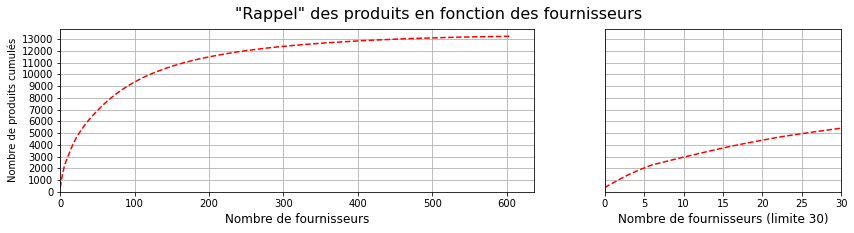

In [24]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(14, 3),
                        gridspec_kw= {'width_ratios': [2, 1]})

for j in range(len(axs)):
    axs[j].plot('index',
                'code_cumsum',
                data=counts.reset_index().reset_index(),
                color='red',
                linestyle='--',
               )
    axs[j].set_xlabel('Nombre de fournisseurs', fontsize=12)
    axs[j].set_ylim(0)
    axs[j].set_xlim(0)
    axs[j].grid(True)
    axs[j].yaxis.set_ticks(np.arange(0, 14000, 1000))

axs[0].set_ylabel('Nombre de produits cumulés')
axs[1].set_xlim(0, 30)
axs[1].set_xlabel('Nombre de fournisseurs (limite 30)', fontsize=12)
axs[1].set_yticklabels([])
for tic in axs[1].yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)

fig.suptitle('"Rappel" des produits en fonction des fournisseurs', fontsize=16)

fig.savefig(Path('..') / 'img' / 'rappel_produit_par_fournisseur.png', bbox_inches='tight')

### Export de quelques désignations et listes d'ingrédients

On exporte quelques désignations pour illuster.

In [25]:
df_des = df_dict['designation']
export_df = (df_des.loc[df_des['data_ok'],
                        ['temp_des',
                         'supplier_des',
                         'supplier_code',
                         'brand',
                         'regulatory_des']]
                   .rename(lab, axis=1)
                   .sample(5, random_state=40)
)
print(export_df)

# Do not overwrite current saved file! 
# It has been corrected manually (midrule was not well placed)
#export_df.to_latex(Path('..') / 'tbls' / 'designation_example.tex',
#                   index=False, 
#                   column_format='p{4cm}p{4cm}p{2cm}p{2cm}p{3cm}',
#                   index_names=False,
#                   )

                                                           Libellé temporaire  \
uid                                                                             
cfb2279a-b1c6-4bab-b21d-dedd4b725e5b  Confiture de mûre en bocal verre 370 g    
b660f69a-577f-4ff1-b67c-da16698135de  Fond de volaille lié hyposodé en boîte    
5ad96ecc-72e2-4716-988b-ea7980649832  Raisins secs golden en sachet 1 kg DOMI   
1417374f-ea74-4274-b20d-e6b4d6626bbd      Fanta citron en canette 33 cl FANTA   
18d09479-6d53-414d-9c71-eb421ba4931f        DIST M4 REFLEX TURQUOISE - 473180   

                                                        Désignation produit fournisseur  \
uid                                                                                       
cfb2279a-b1c6-4bab-b21d-dedd4b725e5b                        BONNE MAMAN CONF MURES 370G   
b660f69a-577f-4ff1-b67c-da16698135de  Fond de volaille lié hyposodé en boîte 800 g N...   
5ad96ecc-72e2-4716-988b-ea7980649832             INDET RAISIN GOLDEN

In [27]:
ingred_mask = df['data_ok'] & ~pd.isna(df['properties.pprodc:ingredientsList'])

sample_ingred = (df.loc[ingred_mask, ['properties.pprodi:supplierDesignation',
                                      'properties.pprodc:ingredientsList']]
                   .rename(lab, axis=1)
                   .sample(10, random_state=42))

with pd.option_context("max_colwidth", 1000):
    print(sample_ingred)
#    sample_ingred.to_latex(Path('..') / 'tbls' / 'ingredient_example.tex',
#                           index=False,
#                           index_names=False,
#                           column_format='p{5cm}p{10cm}',
#                           )
    

                                                                                   Désignation produit fournisseur  \
uid                                                                                                                  
1ad9f10d-fe01-44a2-8a7b-293522f65628                                        PAPILLONS SEMI-COMPLETS BIOLOGIQUE 4KG   
87d82c80-9c5f-4b6c-94d8-d84dcac8aff7                                                               CORN FLAKES 24G   
6620f892-1959-468e-872b-588a07511892                                    Crème de volaille en sachet 20 g NEFF MADA   
b826fe4b-7978-4ea6-84da-51adcbf7b04b                                             Lipton Ice Tea saveur pêche 33 cl   
ed8512da-c1f1-4f9a-9161-fce8d1e6267a  ASSORTIMENT 4 VARIÉTÉS DE PURÉES SANS SUCRES AJOUTES COUPELLES ALUMINIUM 95G   
4b895a76-050d-4e34-badf-f1a639462348             Fond de volaille BIO en sachet doypack 550 g ALLIANCE GASTRONOMIE   
67b51476-bde8-4df0-af87-3f18bdbaae90                    

## Analyse de la complétude des pièces jointes

On jette un oeil au niveau de renseignement des pièces jointes dans le PIM.

In [49]:
file_df = requester.file_report_from_result(mapping={'uid': 'uid'}, index='uid', record_path='entries')
file_df

,has_supplierdatasheet,has_supplierlabel
uid,,
afee12c7-177e-4a68-9539-8cbb68442503,False,False
7d390121-17e8-43bf-a357-9d06b79d2d47,False,False
f234cd84-c8f6-433f-85ec-6e0b6980adc6,True,True
...,...,...
ef42a938-2203-446e-8d28-9fd27c6d3146,False,False
68f5d81b-7f91-40a0-8504-0ec320a86de4,False,False
6dfce29e-fd4c-4670-9f9c-5c02a5b4d52a,False,False


In [50]:
file_df = file_df.join(df)

In [113]:
total_df = file_df.groupby('properties.pprodtop:typeOfProduct').size().to_frame(name='total')
new_idx = pd.MultiIndex.from_tuples([('total', 'total')])
total_df.columns = new_idx
total_df

,total
,total
properties.pprodtop:typeOfProduct,
alcoholicDrink,607
chemistry,459
grocery,8762
hygiene,2501
nonAlcoholicDrink,906


In [156]:
report_df = (
file_df.pivot_table(values=['has_supplierdatasheet', 'has_supplierlabel'],
                    columns=['data_ok', ],
                    index=['properties.pprodtop:typeOfProduct'],
                    aggfunc=['sum', 'count'],
                    margins=True,
                   )
)
report_df2 = report_df.swaplevel(axis=1, i=0, j=2).sort_index(axis=1).stack([0, 1])
report_df2['percent'] = report_df2['sum'] / report_df2['count']
report_df3 = report_df2.unstack(level=[-2, -1]).swaplevel(axis=1, i=0, j=1).swaplevel(axis=1, i=2, j=1).sort_index(axis=1)
report_df3.columns.rename(['data_ok', 'attached', 'func'], inplace=True)
report_df3

data_ok                                           False                                                \
attached                          has_supplierdatasheet                   has_supplierlabel             
func                                              count   percent     sum             count   percent   
properties.pprodtop:typeOfProduct                                                                       
All                                                8722  0.844302  7364.0              8722  0.312543   
alcoholicDrink                                      354  0.836158   296.0               354  0.209040   
chemistry                                           329  0.942249   310.0               329  0.386018   
grocery                                            5755  0.832493  4791.0              5755  0.333797   
hygiene                                            1733  0.870744  1509.0              1733  0.242354   
nonAlcoholicDrink                                   551  0.831216   458.0               551  0.333938   

data_ok                                                    True                                    \
attached                                  has_supplierdatasheet                 has_supplierlabel   
func                                  sum                 count percent     sum             count   
properties.pprodtop:typeOfProduct                                                                   
All                                2726.0                  4513     1.0  4513.0              4513   
alcoholicDrink                       74.0                   253     1.0   253.0               253   
chemistry                           127.0                   130     1.0   130.0               130   
grocery                            1921.0                  3007     1.0  3007.0              3007   
hygiene                             420.0                   768     1.0   768.0               768   
nonAlcoholicDrink                   184.0                   355     1.0   355.0               355   

data_ok                                                               All                     \
attached                                            has_supplierdatasheet                      
func                                percent     sum                 count   percent      sum   
properties.pprodtop:typeOfProduct                                                              
All                                0.979171  4419.0                 13235  0.897393  11877.0   
alcoholicDrink                     1.000000   253.0                   607  0.904448    549.0   
chemistry                          1.000000   130.0                   459  0.958606    440.0   
grocery                            0.996342  2996.0                  8762  0.889979   7798.0   
hygiene                            0.895833   688.0                  2501  0.910436   2277.0   
nonAlcoholicDrink                  0.991549   352.0                   906  0.897351    813.0   

data_ok                                                                
attached                          has_supplierlabel                    
func                                          count   percent     sum  
properties.pprodtop:typeOfProduct                                      
All                                           13235  0.539856  7145.0  
alcoholicDrink                                  607  0.538715   327.0  
chemistry                                       459  0.559913   257.0  
grocery                                        8762  0.561173  4917.0  
hygiene                                        2501  0.443023  1108.0  
nonAlcoholicDrink                               906  0.591611   536.0

In [165]:
type_index = pd.Index(['grocery', 'nonAlcoholicDrink', 'alcoholicDrink', 'hygiene', 'chemistry', 'All'], name='type')
idxs = [[True, False, 'All'], ['has_supplierdatasheet', 'has_supplierlabel'], ['sum', 'count', 'percent']]
col_index = pd.MultiIndex.from_product(idxs, names=['data_ok', 'attached', 'func'])
report_df4 = report_df3.reindex(col_index, axis=1).reindex(type_index)
report_df4

data_ok                            True                                                  \
attached          has_supplierdatasheet               has_supplierlabel                   
func                                sum count percent               sum count   percent   
type                                                                                      
grocery                          3007.0  3007     1.0            2996.0  3007  0.996342   
nonAlcoholicDrink                 355.0   355     1.0             352.0   355  0.991549   
alcoholicDrink                    253.0   253     1.0             253.0   253  1.000000   
hygiene                           768.0   768     1.0             688.0   768  0.895833   
chemistry                         130.0   130     1.0             130.0   130  1.000000   
All                              4513.0  4513     1.0            4419.0  4513  0.979171   

data_ok                           False                                                    \
attached          has_supplierdatasheet                 has_supplierlabel                   
func                                sum count   percent               sum count   percent   
type                                                                                        
grocery                          4791.0  5755  0.832493            1921.0  5755  0.333797   
nonAlcoholicDrink                 458.0   551  0.831216             184.0   551  0.333938   
alcoholicDrink                    296.0   354  0.836158              74.0   354  0.209040   
hygiene                          1509.0  1733  0.870744             420.0  1733  0.242354   
chemistry                         310.0   329  0.942249             127.0   329  0.386018   
All                              7364.0  8722  0.844302            2726.0  8722  0.312543   

data_ok                             All                                                      
attached          has_supplierdatasheet                  has_supplierlabel                   
func                                sum  count   percent               sum  count   percent  
type                                                                                         
grocery                          7798.0   8762  0.889979            4917.0   8762  0.561173  
nonAlcoholicDrink                 813.0    906  0.897351             536.0    906  0.591611  
alcoholicDrink                    549.0    607  0.904448             327.0    607  0.538715  
hygiene                          2277.0   2501  0.910436            1108.0   2501  0.443023  
chemistry                         440.0    459  0.958606             257.0    459  0.559913  
All                             11877.0  13235  0.897393            7145.0  13235  0.539856

In [183]:
(
report_df4.rename({'has_supplierdatasheet': 'Fiche technique',
                   'has_supplierlabel': 'Etiquette',
                   True: 'En qualité',
                   False: 'Hors qualité',
                   'All': 'Total',
                   'sum': 'cpt',
                   'count': 'sur',
                   'percent': '%',
                  }, axis=1)
          .rename({'grocery': 'Epicerie',
                   'nonAlcoholicDrink': 'Boissons',
                   'alcoholicDrink': 'Alcools',
                   'hygiene': 'Hygiène',
                   'chemistry': 'Chimie', 
                   'All': 'Total'})
          .to_latex(Path('..') / 'tbls' / 'attached_files_counts.tex',
                    column_format='lcccccccccccccccccc',
                    bold_rows=True, 
                    index_names=False,
                    formatters=[lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{x:.0%}',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{x:0%}',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{x:0%}',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{x:0%}',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{x:0%}',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{x:0%}',
                               ]
                   )
)